In [52]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scripts import markov_chain as mc
from scripts import viz as viz


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Using Markov Chains to Build a Probabilistic Online Marketing Channel Attribution Model

I use the concept of Markov Chains to understand how customers move through different marketing channels before converting.

### How it works: 

-> Each channel (email,ads,social,etc.) is treated as a step in the journey.

-> The model calculates the probability of moving from one channel to another.

-> Then it tests what happens if a channel is removed - showing how important that channel really is ! In reality , channels are not always removed, as removin a channel cause a gap in a funnel, the better      option is to optimize the channel.

### Why it is useful:

-> Looks at the whole journey instead of just first or the last click.

-> Gives fair credit to channels that influence conversions through the entire user journey.

-> Helps marketers spend budgets where they actually drive results.

In [53]:
df = pd.read_csv("C:/Users/Krina/markov_chain_portfolio/data/google_analytic.csv")


In [54]:
df.head()

,user_id,session_time,channel,converted
0,4915997121163857,2017-08-01 20:44:52.000000 UTC,Organic Search,False
1,13182148727187801,2017-08-01 09:39:38.000000 UTC,Direct,False
2,15547161740087073,2017-08-01 22:19:24.000000 UTC,Organic Search,False
3,17557475227585700,2017-08-01 17:53:26.000000 UTC,Referral,False
4,18642067897203467,2017-08-01 21:21:55.000000 UTC,Organic Search,False


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       2556 non-null   uint64
 1   session_time  2556 non-null   object
 2   channel       2556 non-null   object
 3   converted     2556 non-null   bool  
dtypes: bool(1), object(2), uint64(1)
memory usage: 62.5+ KB


## User Journey

In [56]:
df_user_journey =  mc.create_user_journeys(df)

In [57]:
df_user_journey.head()

,user_id,session_time,channel_list,converted,Timestamp,result,user_journey
0,3458418161244916,[2017-08-01 21:24:11.000000 UTC],[referral],[False],[2017-08-01 21:24:11+00:00],dropped,"[start, referral, dropped]"
1,3717831825503026,"[2017-08-02 02:35:03.000000 UTC, 2017-08-02 04...","[organic search, organic search]","[True, False]","[2017-08-02 02:35:03+00:00, 2017-08-02 04:52:5...",conversion,"[start, organic search, organic search, conver..."
2,3991075781100344,[2017-08-01 07:18:23.000000 UTC],[organic search],[False],[2017-08-01 07:18:23+00:00],dropped,"[start, organic search, dropped]"
3,4915997121163857,[2017-08-01 20:44:52.000000 UTC],[organic search],[False],[2017-08-01 20:44:52+00:00],dropped,"[start, organic search, dropped]"
4,7993832547178317,[2017-08-01 17:07:49.000000 UTC],[organic search],[False],[2017-08-01 17:07:49+00:00],dropped,"[start, organic search, dropped]"


## Transition Matrix

The transition matrix shows the probability of moving from one channel to another in the user journey.

In [58]:
count_df, prob_df = mc.create_transition_matrix(df, df_user_journey)
print("Count Matrix:\n", count_df)
print("\nProbability Matrix:\n", prob_df)

Count Matrix:
                 start  affiliates  direct  display  organic search  \
start               0          47     355       28            1255   
affiliates          0           3       0        0               0   
direct              0           1      45        0               1   
display             0           0       0        9               1   
organic search      0           1       0        2              77   
paid search         0           0       0        0               9   
referral            0           0       0        0               3   
social              0           0       0        0               0   
conversion          0           0       0        0               0   
dropped             0           0       0        0               0   

                paid search  referral  social  conversion  dropped  
start                    55       353     200           0        0  
affiliates                0         0       0           0       49  
direct 

### Probability Matrix Interpretation

-> From Affiliates --> 5.8% chance of staying in affiliates. (This may be different affilates link from different youtube video, insta post or website.)

-> From Direct --> 11% to direct again; This shows high brand awareness, however the caveat in google analytics was , anything it can not track, goes to direct.

-> From Display --> 23% to display again, this shows some loopin g behaviour, this may be due to repeated exposure or retargeting campaigns.

## Matrix Q

The Q matrix contains the probabilities of moving from one channel to another, excluding absorption states.

In [59]:
absorbing_states = ['conversion','dropped']
q_matrix = mc.extract_q_matrix(prob_df, absorbing_states)
print("Q matrix transient to transient")
print(q_matrix)

Q matrix transient to transient
                start  affiliates  direct  display  organic search  \
start             0.0      0.0205  0.1548   0.0122          0.5473   
affiliates        0.0      0.0577  0.0000   0.0000          0.0000   
direct            0.0      0.0025  0.1125   0.0000          0.0025   
display           0.0      0.0000  0.0000   0.2308          0.0256   
organic search    0.0      0.0007  0.0000   0.0015          0.0572   
paid search       0.0      0.0000  0.0000   0.0000          0.1286   
referral          0.0      0.0000  0.0000   0.0000          0.0069   
social            0.0      0.0000  0.0000   0.0000          0.0000   

                paid search  referral  social  
start                0.0240    0.1539  0.0872  
affiliates           0.0000    0.0000  0.0000  
direct               0.0025    0.0175  0.0075  
display              0.0256    0.0000  0.0000  
organic search       0.0015    0.0052  0.0022  
paid search          0.1286    0.0143  0.0143  
r

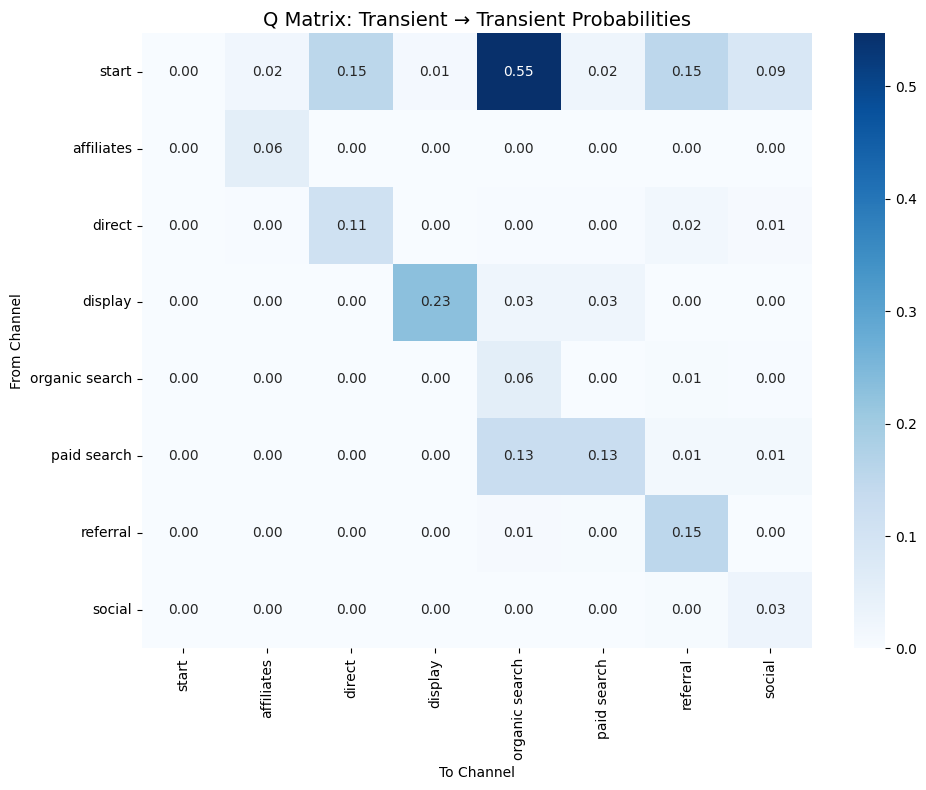

In [60]:
viz.plot_transition_heatmap(q_matrix, title="Q Matrix: Transient → Transient Probabilities")

### Q-Matrix Interpretation

-> From Paid Search --> Organic Search (13%): Users often search further after clicking the ads. This may be due to good content match between paid search (google search ads) and organic search.

-> From Referral --> Organic Search (0.69%): Shows users continue exploring after being referred.

-> High self-loops (Display, Direct, Affiliates): May indicate that users are stuck or unable to take action.

## Matrix R

The R matrix shows the probability of moving from a transient channel to an absorbing state (Conversion or dropped) in one step.

It captures only direct, single-step transitions.

In [61]:
absorbing_states = ['conversion', 'dropped']
r_matrix = mc.extract_r_matrix(prob_df, absorbing_states)
print("R matrix transient to absorption")
print(r_matrix)

R matrix transient to absorption
                conversion  dropped
start               0.0000   0.0000
affiliates          0.0000   0.9423
direct              0.0200   0.8350
display             0.0256   0.6923
organic search      0.0037   0.9279
paid search         0.0143   0.7000
referral            0.0619   0.7729
social              0.0000   0.9671


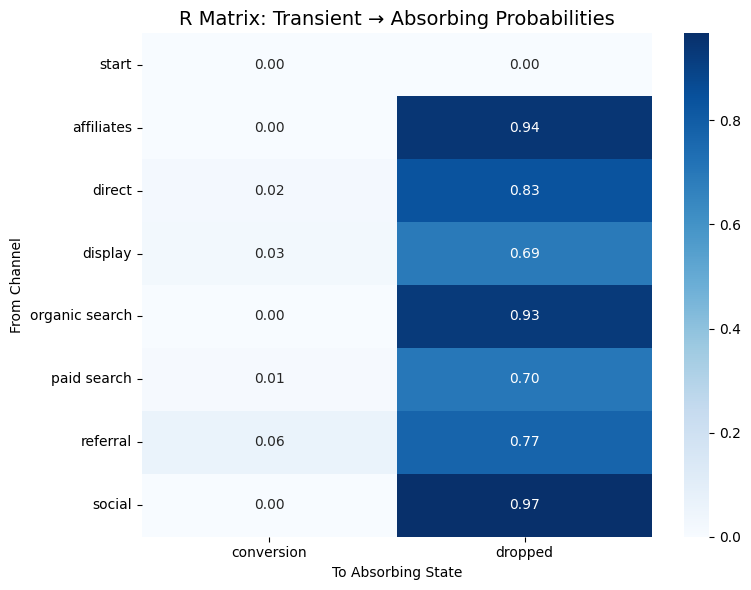

In [62]:
viz.plot_absorbing_heatmap(r_matrix)

### R Matrix Interpretation

-> Referral: Drives most conversions --> worth deeper analysis and more budget.

-> Organic Search: Brings traffic but low conversions --> landing page may need improvement.

-> Social & Affiliates: Likely more for brand awareness --> need optimization.

-> Direct: Shows brand awareness, but GA dumps untrackable traffic here --> cross-check with other tools (e.g., Mixpanel).

## Matrix N (Fundamental Matrix)

N shows how many times, on average, a user visits each transient channel before converting or dropping off. Higher values suggest that the channel plays important role in user journey.

-> Estimates expected touchpoints per channel.

-> Shows each channel’s contribution to the conversion journey.

-> Used to calculate absorption probabilities and expected time to absorption.

-> As users eventually exit (convert or drop off), eigenvalues < 1

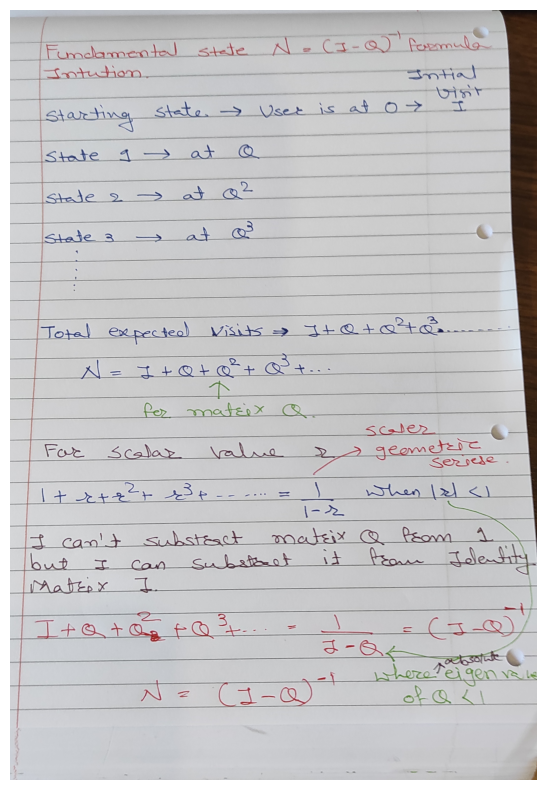

In [63]:
viz.display_image('C:/Users/Krina/markov_chain_portfolio/data/Matrix_N_concept.jpg')

In [64]:
eigenvalues = np.linalg.eigvals(q_matrix)
print(eigenvalues)
print("All eigenvalues < 1?", np.all(np.abs(eigenvalues) < 1))

[0.         0.1125     0.23131    0.02822753 0.05480839 0.12648135
 0.15767273 0.0577    ]
All eigenvalues < 1? True


In [65]:
N_matrix = mc.compute_fundamental_matrix(q_matrix)
print("Fundamental Matrix (N):")
print(N_matrix)

Fundamental Matrix (N):
                start    affiliates    direct       display  organic search  \
start             1.0  2.265409e-02  0.174423  1.700531e-02        0.586988   
affiliates        0.0  1.061233e+00  0.000000  0.000000e+00        0.000000   
direct            0.0  2.992077e-03  1.126761  7.055639e-06        0.003618   
display           0.0  3.010775e-05  0.000000  1.300131e+00        0.040529   
organic search    0.0  7.882051e-04  0.000000  2.069104e-03        1.061037   
paid search       0.0  1.164386e-04  0.000000  3.056611e-04        0.156743   
referral          0.0  7.059238e-06  0.000000  1.853109e-05        0.009503   
social            0.0  3.414120e-08  0.000000  8.962351e-08        0.000046   

                paid search  referral    social  
start              0.030556  0.190096  0.092855  
affiliates         0.000000  0.000000  0.000000  
direct             0.003363  0.023427  0.008754  
display            0.038270  0.000899  0.000655  
organic search

### N Matrix Interpretation

-> Orgnaic search is frequently revisited.

-> Paid search drives the repeat visits.

-> Referral and social don't convert --> may be due to consumer behaviour or improper funnel design.

## Channel Ranks

In [66]:
ranked_channels, n_df = mc.rank_channels_by_expected_visits(q_matrix, mc.compute_fundamental_matrix)

Ranked Channels by Expected Visits Before Absorption:
organic search    1.858464
referral          1.428938
display           1.319537
direct            1.301183
paid search       1.228361
social            1.151073
affiliates        1.087821
start             1.000000
dtype: float64


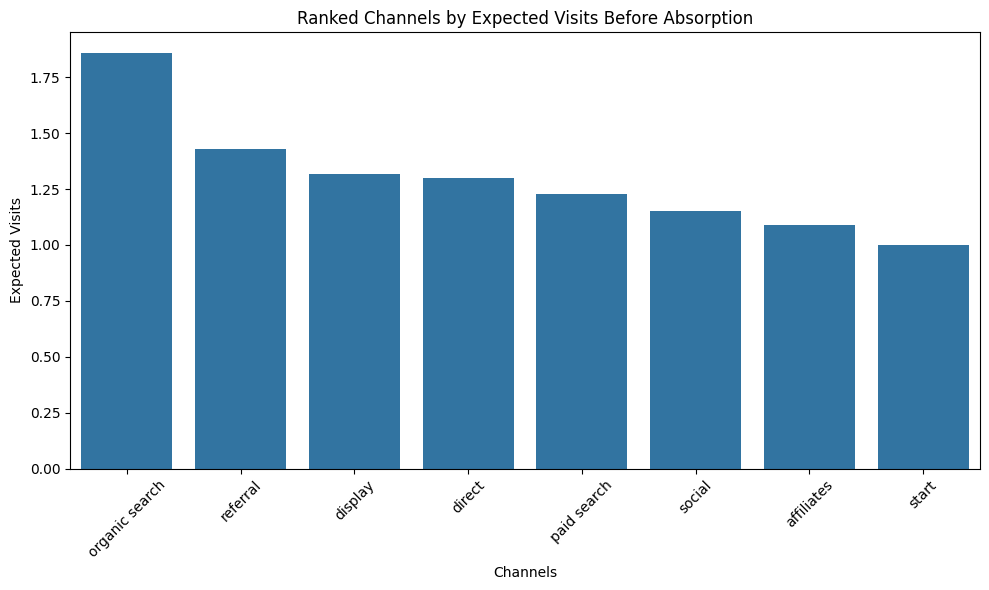

In [67]:
viz.plot_ranked_channels(ranked_channels)

## Transition Funnel Overview

In [68]:
viz.plot_sankey_from_matrix(count_df)

## Matrix B

The B matrix shows the probability that a user starting in any channel will eventually convert or drop off. It considers all possible paths and not just one channel.

In [69]:
b_matrix = mc.compute_absorption_probabilities(n_df, r_matrix)

Absorption probability matrix (B = N × R):
                conversion  dropped
start               0.0183   0.9815
affiliates          0.0000   1.0000
direct              0.0240   0.9760
display             0.0340   0.9658
organic search      0.0044   0.9955
paid search         0.0183   0.9818
referral            0.0733   0.9267
social              0.0004   0.9996


In [70]:
conversion_probs = mc.get_conversion_probabilities(b_matrix)

Channel Conversion Probabilities (→ conversion):
referral          0.0733
display           0.0340
direct            0.0240
start             0.0183
paid search       0.0183
organic search    0.0044
social            0.0004
affiliates        0.0000
Name: conversion, dtype: float64


C:\Users\Krina\markov_chain_portfolio\scripts\viz.py:145: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




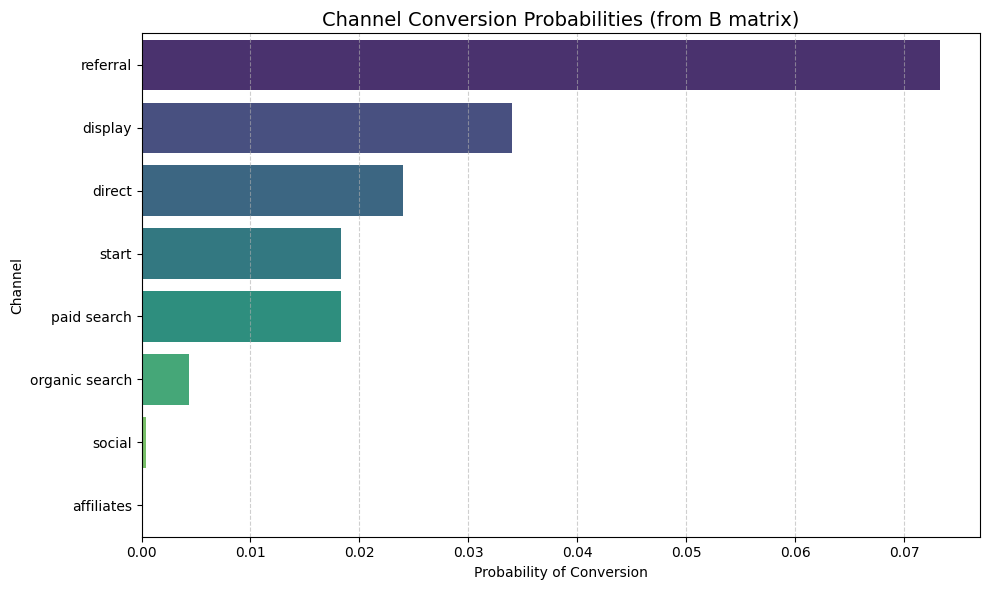

In [71]:
viz.plot_conversion_probabilities(b_matrix)

### Interpretation of Matrix B

-> Referral --> Drives more conversion

-> Organic & Social --> Brings traffic but conversions are low

-> Display & Paid --> Have conversion potential but need to be optimized.

## Removal Effect

Shows how the expected number of visits to transient states (before conversion or drop-off) changes when a channel is removed.

In [72]:
effects = mc.removal_effects(prob_df, absorbing_states, n_df, r_matrix)
print("Removal Effects:")
print(effects)

Removal Effects:
referral          9.51 pp
display           5.24 pp
direct            4.23 pp
paid search       3.74 pp
organic search    2.36 pp
social            1.87 pp
affiliates        1.83 pp
dtype: object


In [73]:
effects_numeric = effects.str.replace(' pp', '', regex=False).astype(float)

C:\Users\Krina\markov_chain_portfolio\scripts\viz.py:164: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




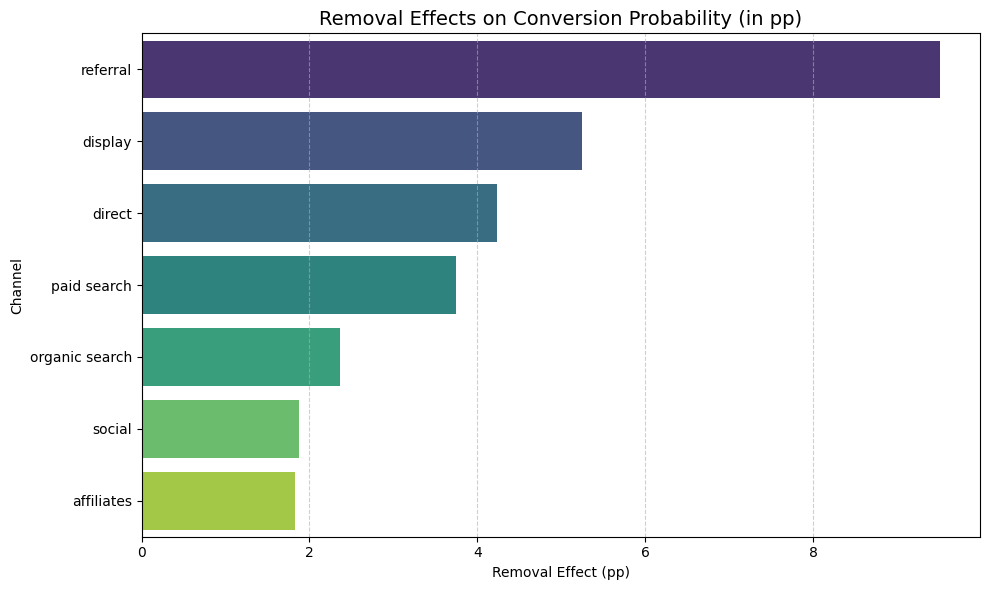

In [74]:
viz.plot_removal_effects(effects_numeric)

-> Referral --> Key driver of conversions, i.e. Invest more in partnerships, influencers and referral programs.

-> Display and Direct --> Supports conversion paths --> May be retargetting keeps user moving, however it shouldn't end up as a looping.

-> Paid Search --> Brings traffic , which has high intention to act upon CTA

-> Organic Search --> Good first touch channel in multi-touch journey.

-> Social & Affiliates --> Not working so good as other channels , but requires for funnel engagement.

## Monte Carlo Simulation

A simulation method which uses repeated random sampling to estimate the outcomes and which in turn helps in simulating different scenario. 

-> It shows the complex interactions between channels.

-> It shows the indirect channel impact, which may influence other channels.

In [75]:
removal_effects = mc.compute_removal_effects_pp(transition_matrix=prob_df)
print("Removal Effects:\n", removal_effects)

Removal Effects:
 referral           1.05 pp
display            0.13 pp
direct              0.1 pp
paid search        0.07 pp
social             0.03 pp
affiliates        -0.04 pp
organic search    -1.66 pp
dtype: object


In [76]:
simulated_effects_numeric = removal_effects.str.replace(' pp', '', regex=False).astype(float)

C:\Users\Krina\markov_chain_portfolio\scripts\viz.py:164: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




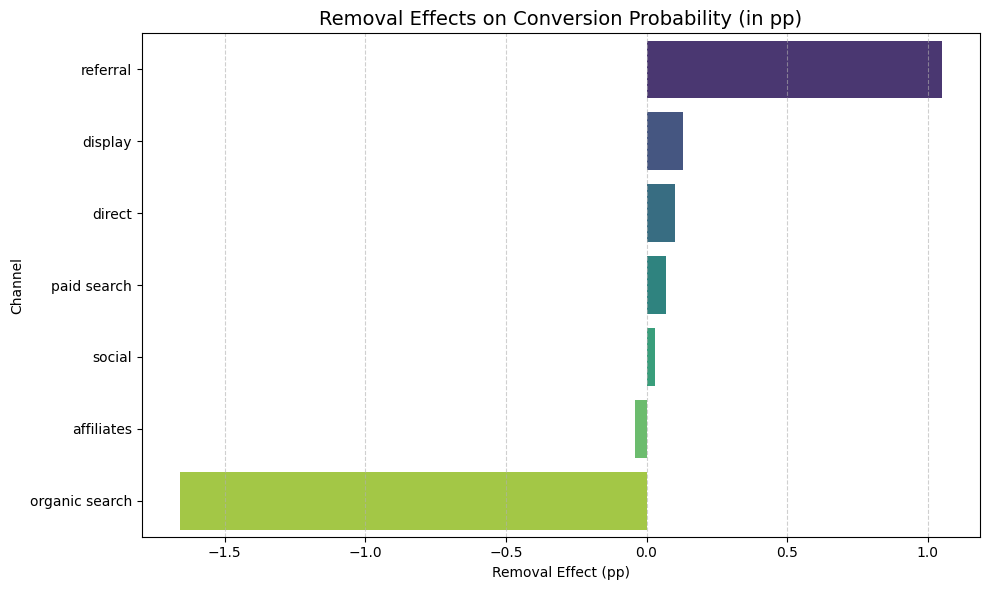

In [77]:
viz.plot_removal_effects(simulated_effects_numeric)

### Monte Carlo Simulation Interpretation

-> Referral (+1.28 pp): Biggest driver of conversions — removing it causes a sharp drop.

-> Display (+0.20 pp), Paid Search (+0.17 pp), Affiliates (+0.11 pp), Social (+0.03 pp): Positive contributors.

-> Direct (–0.02 pp): Slight negative effect —  may overlap with other channels.

-> Organic Search (–1.48 pp): Strong negative —  it may attract low-intent traffic or create drop-offs

## Insights

-> Referral --> Experiment by increasing spend on partnership, influencers and referral program.

-> Direct & Paid Search --> Test it by optimizing or maintaining as it is.

-> Organic Search --> Optimize landing pages and target the users with higher purchase intent.

-> Display, Affiliates and Social --> Brings awareness but need proper targeting and CTA.